In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
class ConvolutionNetwork:
  def __init__(self,n_kernals=10,units = 10,batch_size = 32,learning_rate = 0.1):
    self.n_kernals = n_kernals
    self.kernal_size = 3
    self.optimizer = None
    self.conv_w = None
    self.conv_b = None
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
 
  def forpass(self,x):
    c_out = tf.nn.conv2d(x,self.conv_w,strides=1,padding = "SAME") + self.conv_b
    r_out = tf.nn.relu(c_out)
    p_out = tf.nn.max_pool2d(r_out,ksize=2,strides=2,padding = "VALID")
    f_out = tf.reshape(p_out,[x.shape[0],-1])
    z1 = tf.matmul(f_out,self.w1) + self.b1
    a1 =tf.nn.relu(z1)
    z2 = tf.matmul(a1,self.w2) + self.b2
    return z2
  def init_weights(self,input_shape,n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3,3,1,self.n_kernals)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernals),dtype=float)
    n_features = 14 * 14 * self.n_kernals
    self.w1 = tf.Variable(g((n_features,self.units)))
    self.b1 = tf.Variable(np.zeros(self.units),dtype=float)
    self.w2 = tf.Variable(g((self.units,n_classes)))
    self.b2 = tf.Variable(np.zeros(n_classes),dtype=float)
  def fit(self,x,y,epochs = 100,x_val = None,y_val = None):
    self.init_weights(x.shape,y.shape[1])
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    for i in range(epochs):
      loss = 0
      batch_losses = []
      for x_batch,y_batch in self.gen_batch(x,y):
        self.training(x_batch,y_batch)
        batch_losses.append(self.get_loss(x_batch,y_batch))

      self.losses.append(np.mean(batch_losses))
      self.get_loss(x_val,y_val)
  def gen_batch(self,x,y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size: 
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start : end],y[start :end]

  def training(self,x,y):
    m = len(x)

    with tf.GradientTape() as tape:
      z = self.forpass(x)
      loss = tf.nn.softmax_cross_entropy_with_logits(y,z)
      loss = tf.reduce_mean(loss)
    weights_list = [self.conv_w,self.conv_b,self.w1,self.b1,self.w2,self.w2]
    grads = tape.gradient(loss,weights_list)
    self.optimizer.apply_gradients(zip(grads,weights_list))
  
  def predict(self,x):
    z = self.forpass(x)
    return np.argmax(z.numpy(),axis = 1)
  def score(self,x,y):
    return np.mean(self.predict(x)==np.argmax(y,axis=1))
  def get_loss(self,x,y):
    z = self.forpass(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,z))
    return loss.numpy()



In [ ]:
(x_train_all,y_train_all),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x_train_all,y_train_all,stratify = y_train_all,test_size=0.2,random_state = 42)
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)

x_train = x_train / 255
x_val = x_val / 255

In [ ]:
cn = ConvolutionNetwork(n_kernals=10,units = 100,batch_size=128,learning_rate=0.01)
cn.fit(x_train,y_train_encoded,x_val=x_val,y_val=y_val_encoded,epochs = 20)

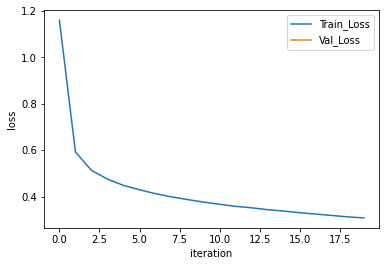

In [ ]:
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel("loss")
plt.xlabel("iteration")
plt.legend(["Train_Loss","Val_Loss"])
plt.show()

In [ ]:
cn.score(x_val,y_val_encoded)

0.87575

In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense

In [ ]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape = (28,28,1)))
conv1.add(MaxPooling2D((2,2)))
conv1.add(Flatten())
conv1.add(Dense(100,activation='relu'))
conv1.add(Dense(10,activation="softmax"))


In [ ]:
conv1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv1.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics = ["accuracy"])
history = conv1.fit(x_train,y_train_encoded,epochs = 20,validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.4402 - accuracy: 0.8453 - val_loss: 0.3384 - val_accuracy: 0.8794
Epoch 2/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3094 - accuracy: 0.8892 - val_loss: 0.3119 - val_accuracy: 0.8879
Epoch 3/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.2649 - accuracy: 0.9033 - val_loss: 0.2708 - val_accuracy: 0.9022
Epoch 4/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.2306 - accuracy: 0.9143 - val_loss: 0.2478 - val_accuracy: 0.9131
Epoch 5/20
1500/1500 [==============================] - 29s 20ms/step - loss: 0.2050 - accuracy: 0.9236 - val_loss: 0.2850 - val_accuracy: 0.8983
Epoch 6/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.1820 - accuracy: 0.9324 - val_loss: 0.2497 - val_accuracy: 0.9128
Epoch 7/20
1500/1500 [==============================] - 30s 20ms/step - loss: 0.1626 - accuracy: 0.9388 - val_loss: 0.2598 -

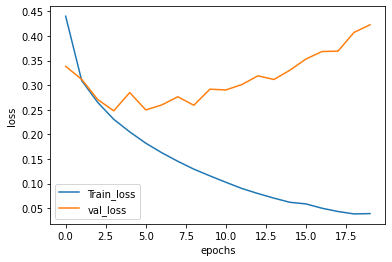

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train_loss","val_loss"])
plt.show()

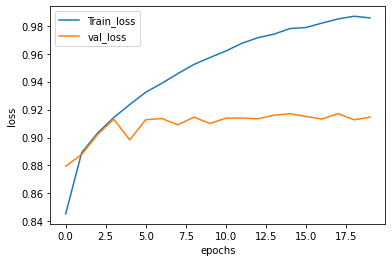

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train_loss","val_loss"])
plt.show()

In [ ]:
loss,accuracy = conv1.evaluate(x_val,y_val_encoded,verbose = 0)
accuracy

0.9145833253860474

In [ ]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10,(3,3),activation='relu',padding='same',input_shape = (28,28,1)))
conv2.add(MaxPooling2D((2,2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100,activation='relu'))
conv2.add(Dense(10,activation="softmax"))
conv2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [ ]:
conv2.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics = ["accuracy"])
history = conv2.fit(x_train,y_train_encoded,epochs = 20,validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 42s 28ms/step - loss: 0.5097 - accuracy: 0.8159 - val_loss: 0.3451 - val_accuracy: 0.8800
Epoch 2/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.3752 - accuracy: 0.8613 - val_loss: 0.3113 - val_accuracy: 0.8889
Epoch 3/20
1500/1500 [==============================] - 45s 30ms/step - loss: 0.3373 - accuracy: 0.8752 - val_loss: 0.2967 - val_accuracy: 0.8912
Epoch 4/20
1500/1500 [==============================] - 46s 31ms/step - loss: 0.3085 - accuracy: 0.8868 - val_loss: 0.2806 - val_accuracy: 0.8957
Epoch 5/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.2894 - accuracy: 0.8924 - val_loss: 0.2738 - val_accuracy: 0.8984
Epoch 6/20
1500/1500 [==============================] - 42s 28ms/step - loss: 0.2780 - accuracy: 0.8966 - val_loss: 0.2612 - val_accuracy: 0.9018
Epoch 7/20
1500/1500 [==============================] - 41s 28ms/step - loss: 0.2614 - accuracy: 0.9025 - val_loss: 0.2449 -

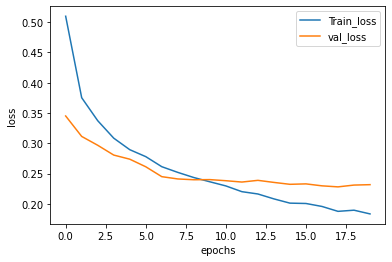

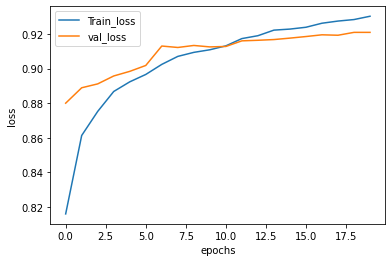

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train_loss","val_loss"])
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Train_loss","val_loss"])
plt.show()

In [ ]:
loss,accuracy = conv2.evaluate(x_val,y_val_encoded,verbose = 0)
accuracy

0.9210000038146973